In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import math

In [2]:
import tensorflow as tf

2024-05-27 00:13:47.131155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 00:13:47.301720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-27 00:13:47.301749: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-27 00:13:47.339036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 00:13:48.186139: W tensorflow/stream_executor/platform/de

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, LSTM, Bidirectional, Dropout, Concatenate
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [4]:
from numpy.lib.stride_tricks import sliding_window_view

In [5]:
from IPython.display import clear_output

## Import data and transform to dataframe

In [6]:
info = pd.DataFrame({})

In [7]:
# Load CSV with the metadata of each sensor file

for folder_distance in ['two_tubes_16cm_4cm','two_tubes_10cm_4cm','two_tubes_8cm_2cm','two_tubes_12cm_6cm','two_tubes_16cm_6cm','two_tubes_14cm_4cm','two_tubes_8cm_6cm','two_tubes_6cm_4cm','two_tubes_14cm_6cm','two_tubes_12cm_4cm','two_tubes_10cm_6cm']:
 
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info = pd.concat([info, info_aux])

In [8]:
# This function is used mainly to join the original
# bitstream information to each file. It also creates 
# columns for visualization

def add_inputs_labels(df,row,i,injection_time,injection_amount,bit_duration):
    input_name = 'input_' + str(i)
    bitstream_name = 'bitstream_' + str(i)
    
    df[input_name] = 0
    df[bitstream_name] = row[bitstream_name][1:]

    time_add = 0
    for count, bit in enumerate(row[bitstream_name][1:].split()[0]):
        df.loc[(df.sim_time <= injection_time + time_add) & (df.sim_time >= time_add),input_name] = injection_amount*int(bit)
        time_add += bit_duration
    return df

In [9]:
# Load data from each sensor csv into a dataframe dictionary

data = {}

for index,row in info.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::10].reset_index(drop=True)
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,500,1)
        distance_name = 'distance_' + str(i)
        data_aux[distance_name] = row[distance_name]
    data.update({index: data_aux})


In [12]:
data[350]

sim_time  molecule_count  input_0           bitstream_0  distance_0  \
0        0.00               0      500  10000011010101000110        0.14   
1        0.05               0      500  10000011010101000110        0.14   
2        0.10               0      500  10000011010101000110        0.14   
3        0.15               0        0  10000011010101000110        0.14   
4        0.20               0        0  10000011010101000110        0.14   
..        ...             ...      ...                   ...         ...   
496     24.80               2        0  10000011010101000110        0.14   
497     24.85               2        0  10000011010101000110        0.14   
498     24.90               2        0  10000011010101000110        0.14   
499     24.95               1        0  10000011010101000110        0.14   
500     25.00               1        0  10000011010101000110        0.14   

     input_1           bitstream_1  distance_1  
0          0  01001010001000110000        0.16  
1          0  01001010001000110000        0.16  
2          0  01001010001000110000        0.16  
3          0  01001010001000110000        0.16  
4          0  01001010001000110000        0.16  
..       ...                   ...         ...  
496        0  01001010001000110000        0.16  
497        0  01001010001000110000        0.16  
498        0  01001010001000110000        0.16  
499        0  01001010001000110000        0.16  
500        0  01001010001000110000        0.16  

[501 rows x 8 columns]

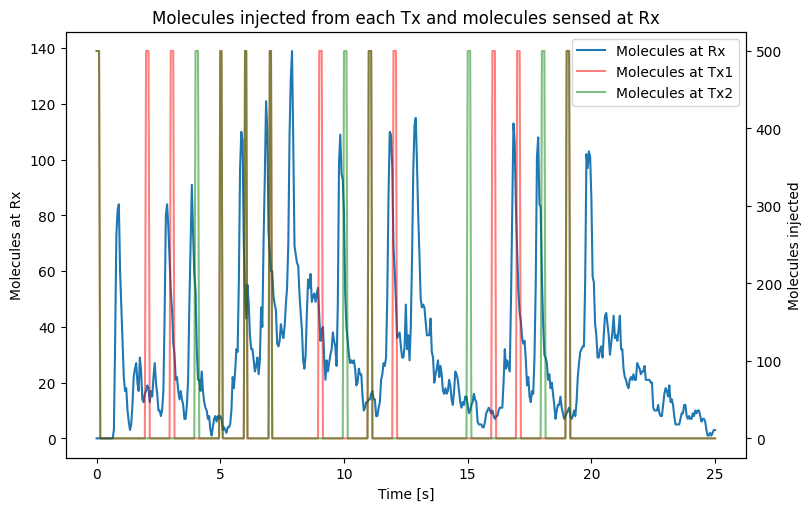

In [14]:
#Visualize each dataset
chosen_dataset = 145

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
#fig.savefig("two_sources_10_2.png", dpi=300)

In [15]:
#Separate datasets to see performance on unseen data

data_test = dict(list(data.items())[math.floor(len(data)*0.7):len(data)-1])
data = dict(list(data.items())[:math.floor(len(data)*0.7)])

## Data Augmentation and train/test split

In [16]:
# Data augmentation process, creation of input and output matrix

n_original = len(data)
n_copies = 5 # How many new datasets will be generated from one sample
index = n_original-1

for i in range(0,n_original):
    data_aux = data[i]
    for j in range(0,n_copies):
        data_aux['molecule_count'] = np.random.poisson(data[i]['molecule_count']) # Add poisson noise
        data.update({index: data_aux})

In [17]:
# Create the input and output matrix
    
x_all = np.zeros((len(data),data[0]['molecule_count'].size))
y_all = np.zeros((len(data),2))

for i in range(0,len(data)):
    x_all[i] = data[i]['molecule_count']
    y_all[i] = [data[i]['distance_0'][0],data[i]['distance_1'][0]]


In [18]:
# Input and output matrix for testing

test_key_list = list(data_test.keys())
first_item = test_key_list[0]

x_all_test = np.zeros((len(data_test),data_test[first_item]['molecule_count'].size))
y_all_test = np.zeros((len(data_test),2))

for i in range(first_item+1,first_item + len(data_test)):
    x_all_test[i-first_item] = data_test[i]['molecule_count']
    y_all_test[i-first_item] = [data_test[i]['distance_0'][0],data_test[i]['distance_1'][0]]

In [19]:
# Split test dataset into test and validation sets

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.001, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_all_test, y_all_test, test_size=0.33, random_state=42)

In [20]:
# Sliding windows functions to obtain the input and output synchronized
# bit_size: number of samples a bit takes in the pogona bitstream
# bit_amount: number of bits the sliding window will take
# stride: overlap for the sliding window, how many bits advances
# source_amount: quantity of sources
# extra_padding: how many extra samples are to be taken in the window

def apply_sliding_window(df_x,df_y,bit_size,bit_amount,stride,source_amount,extra_padding,cir,bit_total):
    window_size = bit_size*bit_amount
    sample_size = df_x.shape[0]
    
    if cir == True:
        window_amount = bit_total-bit_amount+1
        df_y = np.repeat(df_y,window_amount,axis=0)

    df_x = sliding_window_view(df_x,window_shape=window_size+extra_padding,axis=1)[:,::bit_size*stride]
    df_x = df_x[:,:window_amount]
    df_x = df_x.reshape(df_x.shape[0]*window_amount,window_size+extra_padding)
    
    return df_x,df_y

In [21]:
# Sliding windows parameters

bit_amount = 6 #How many bits you want for the window
bit_size = int(200/10) # How many samples per bit
source_amount = 2
extra_padding = int(200/10)


In [22]:
x_train,y_train = apply_sliding_window(x_train,y_train,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)
x_test,y_test = apply_sliding_window(x_test,y_test,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)
x_val,y_val = apply_sliding_window(x_val,y_val,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)

In [23]:
n_train_batches = x_train.shape[0]

n_x = x_train.shape[1]
n_y = y_train.shape[1]

In [24]:
n_test_batches = x_test.shape[0]
n_val_batches = x_val.shape[0]

## Data training

In [25]:
# Neural Network Architecture

inputs = tf.keras.Input(shape=(1,n_x))

lstm_layer = Bidirectional(LSTM(128, return_sequences=True))
lstm_layer_2 = Bidirectional(LSTM(128, return_sequences=True))
#lstm_layer_3 = Bidirectional(LSTM(128, return_sequences=True))
#lstm_layer_4 = Bidirectional(LSTM(128, return_sequences=True))
x_1 = lstm_layer(inputs)
x_2 = lstm_layer_2(x_1)
#x_3 = lstm_layer_3(x_2)
#x_4 = lstm_layer_4(x_3)
hidden_dense = Dense(units=256, activation='relu')(x_2)
hidden_dense_2 = Dense(units=256, activation='relu')(hidden_dense)
#hidden_dense_3 = Dense(units=256, activation='relu')(hidden_dense_2)
#hidden_dense_4 = Dense(units=256, activation='relu')(hidden_dense_3)

output = Dense(units=n_y, activation='relu')(hidden_dense_2)

2024-05-27 00:16:24.664096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-27 00:16:24.664550: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-27 00:16:24.664589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-ubuntu): /proc/driver/nvidia/version does not exist
2024-05-27 00:16:24.665761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Tensorflow model creation

lstm_model = Model(inputs=inputs, outputs=output, name="lstm_model")


In [27]:
# Dataset normalization

def normalize_df(df):
    df_mean = np.mean(df)
    df_std = np.std(df)
    
    if df_std == 0:
        return df
    else:
        return (df - df_mean)/df_std

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
def normalize_df(df):
    scaler = MinMaxScaler()
    #print(df.shape)
    return scaler.fit_transform(df.reshape(df.size,1))

In [30]:
# Input Normalization

x_train = np.array(list(map(normalize_df,x_train)))
x_test = np.array(list(map(normalize_df,x_test)))
x_val = np.array(list(map(normalize_df,x_val)))

In [31]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 140)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           275456    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1, 256)            65792     
                                                                 
 dense_1 (Dense)             (None, 1, 256)            65792     
                                                                 
 dense_2 (Dense)             (None, 1, 2)              5

In [32]:
# Training and validation

history = lstm_model
patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

history.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

#x_train = normalize_df(x_train)

x_train = x_train.reshape(n_train_batches,1,n_x)
y_train = y_train.reshape(n_train_batches,1,n_y)

x_val = x_val.reshape(n_val_batches,1,n_x)
y_val = y_val.reshape(n_val_batches,1,n_y)

clear_output(wait=True)
history_data = history.fit(x=x_train,y=y_train,epochs=20, validation_data=(x_val,y_val),)
         # callbacks=[early_stopping])
    #x.append(x_eval)
    #y.append(y_eval)

#x = data[i].drop(columns=['data_index','distance'])
#y = np.array(ast.literal_eval(data[i]['bitstream'][0]))




#compile_and_fit(x_eval,y,history)





Epoch 1/20
361/361 [==============================] - 15s 18ms/step - loss: 5.0041e-04 - mean_absolute_error: 0.0139 - val_loss: 3.0429e-04 - val_mean_absolute_error: 0.0132
Epoch 2/20
361/361 [==============================] - 5s 13ms/step - loss: 2.5188e-04 - mean_absolute_error: 0.0105 - val_loss: 3.3214e-04 - val_mean_absolute_error: 0.0122
Epoch 3/20
361/361 [==============================] - 5s 13ms/step - loss: 2.3379e-04 - mean_absolute_error: 0.0099 - val_loss: 2.2063e-04 - val_mean_absolute_error: 0.0102
Epoch 4/20
361/361 [==============================] - 5s 13ms/step - loss: 2.2428e-04 - mean_absolute_error: 0.0096 - val_loss: 2.0475e-04 - val_mean_absolute_error: 0.0087
Epoch 5/20
361/361 [==============================] - 5s 13ms/step - loss: 2.1371e-04 - mean_absolute_error: 0.0092 - val_loss: 2.5487e-04 - val_mean_absolute_error: 0.0092
Epoch 6/20
361/361 [==============================] - 5s 13ms/step - loss: 2.1599e-04 - mean_absolute_error: 0.0093 - val_loss: 2.1597

In [33]:
from matplotlib.ticker import MaxNLocator

/tmp/ipykernel_6978/3499729020.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


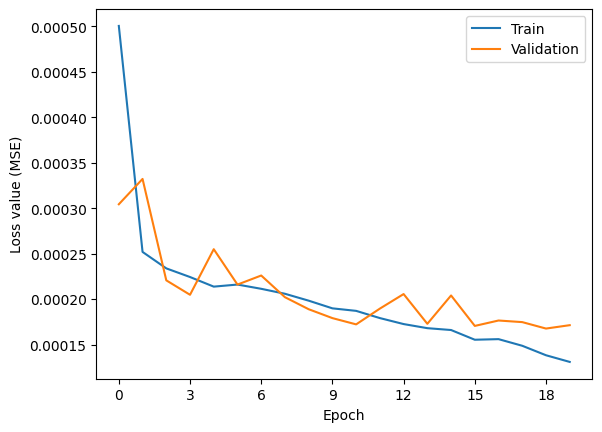

In [34]:
fig, ax = plt.subplots()

plt.plot(history_data.history['loss'])
plt.plot(history_data.history['val_loss'])


#plt.title('Loss value')
ax.set_ylabel('Loss value (MSE)')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(['Train', 'Validation'], loc='upper right')
fig.show()
fig.savefig('loss_mse_two_tubes_distance_estimation',dpi=300)

In [ ]:
# Model saving

#history.save('two_tubes_distance_model')

In [ ]:
info_test = pd.DataFrame({})

In [148]:
# Testing dataset metadata

info_test = pd.DataFrame({})
for folder_distance in ['two_tubes_14cm_5cm','two_tubes_7cm_3cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info_test = pd.concat([info_test, info_aux]) 

In [149]:
# Testing dataset loading into dictionary

data_test = {}


for index,row in info_test.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::].reset_index(drop=True)
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,5,1)
        distance_name = 'distance_' + str(i)
        data_aux[distance_name] = row[distance_name]
    data_test.update({index: data_aux})


In [35]:
# Input and output matrix for testing

test_key_list = list(data_test.keys())
first_item = test_key_list[0]

x_all_test = np.zeros((len(data_test),data_test[first_item]['molecule_count'].size))
y_all_test = np.zeros((len(data_test),2))

for i in range(first_item+1,first_item + len(data_test)):
    x_all_test[i-first_item] = data_test[i]['molecule_count']
    y_all_test[i-first_item] = [data_test[i]['distance_0'][0],data_test[i]['distance_1'][0]]

In [242]:
x_test_new,y_test_new = apply_sliding_window(x_all_test,y_all_test,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)

In [30]:
x_test,y_test = apply_sliding_window(x_test,y_test,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)

ValueError: cannot reshape array of size 501900 into shape (53775,140)

In [36]:
# Testing

y_pred_aux = history.predict(x_test.reshape(x_test.shape[0],1,x_test.shape[1]))

104/104 [==============================] - 2s 6ms/step


In [37]:
y_pred_aux = y_pred_aux.reshape(y_pred_aux.shape[0],y_pred_aux.shape[2])

In [38]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [39]:
mae(y_test,y_pred_aux)

0.007689047778375129

In [40]:
# Dataframe for distance class performance comparison

unseen_data_test = pd.concat([pd.DataFrame(y_pred_aux,columns=['yp_d_0','yp_d_1']), pd.DataFrame(y_test,columns=['y_gt_d_0','y_gt_d_1'])],axis=1)

In [41]:
unseen_data_test['d_0_dif'] = unseen_data_test['yp_d_0'] - unseen_data_test['y_gt_d_0']

In [42]:
unseen_data_test['d_1_dif'] = unseen_data_test['yp_d_1'] - unseen_data_test['y_gt_d_1']

In [43]:
unseen_data_test['dif'] = ((unseen_data_test['yp_d_0']-unseen_data_test['y_gt_d_0'])**2+(unseen_data_test['yp_d_1']-unseen_data_test['y_gt_d_1'])**2)**(1/2)/(unseen_data_test['y_gt_d_0']**2+unseen_data_test['y_gt_d_1']**2)**(1/2)

In [44]:
unseen_data_test['class'] = unseen_data_test.apply(lambda x: str([x['y_gt_d_0'],x['y_gt_d_1']]),axis=1)


In [45]:
#unseen_data_test.to_csv('unseen_data_comparison_14_5.csv')

In [46]:
unseen_data_test['dif']

0       0.035965
1       0.023912
2       0.026859
3       0.037005
4       0.025662
          ...   
3295    0.019912
3296    0.012587
3297    0.017959
3298    0.009129
3299    0.018688
Name: dif, Length: 3300, dtype: float64

In [48]:
unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[1]]

yp_d_0    yp_d_1  y_gt_d_0  y_gt_d_1   d_0_dif   d_1_dif       dif  \
15    0.100114  0.158559       0.1      0.16  0.000114 -0.001441  0.007663   
16    0.100109  0.159612       0.1      0.16  0.000109 -0.000388  0.002136   
17    0.100134  0.160464       0.1      0.16  0.000134  0.000464  0.002561   
18    0.099955  0.159174       0.1      0.16 -0.000045 -0.000826  0.004383   
19    0.099504  0.159336       0.1      0.16 -0.000496 -0.000664  0.004393   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.099495  0.157833       0.1      0.16 -0.000505 -0.002167  0.011793   
3131  0.098839  0.158619       0.1      0.16 -0.001161 -0.001381  0.009563   
3132  0.099651  0.158764       0.1      0.16 -0.000349 -0.001236  0.006806   
3133  0.100079  0.158619       0.1      0.16  0.000079 -0.001381  0.007330   
3134  0.100129  0.158746       0.1      0.16  0.000129 -0.001254  0.006681   

            class  
15    [0.1, 0.16]  
16    [0.1, 0.16]  
17    [0.1, 0.16]  
18    [0.1, 0.16]  
19    [0.1, 0.16]  
...           ...  
3130  [0.1, 0.16]  
3131  [0.1, 0.16]  
3132  [0.1, 0.16]  
3133  [0.1, 0.16]  
3134  [0.1, 0.16]  

[165 rows x 8 columns]

In [49]:
classes = unseen_data_test['class'].unique()

In [52]:
classes

array(['[0.14, 0.22]', '[0.1, 0.16]', '[0.12, 0.18]', '[0.14, 0.24]',
       '[0.14, 0.16]', '[0.12, 0.14]', '[0.14, 0.18]', '[0.14, 0.2]',
       '[0.12, 0.2]', '[0.12, 0.24]', '[0.12, 0.22]'], dtype=object)

In [51]:
classes = np.delete(classes,11)

In [53]:
# Performance results

class_data = pd.DataFrame()

for i in range(0,len(classes)):
    aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[i]]
    aux_data = pd.DataFrame(index = [i],data = {"class": [classes[i]],"95_dif": [aux[aux['dif']<=0.05].count()[0]/aux.count()[0]*100]} )
    aux_data['90_dif'] = aux[aux['dif']<=0.1].count()[0]/aux.count()[0]*100
    aux_data['80_dif'] = aux[aux['dif']<=0.2].count()[0]/aux.count()[0]*100
    aux_data['50_dif'] = aux[aux['dif']<=0.5].count()[0]/aux.count()[0]*100
    aux_data['MAE'] = (abs(aux['yp_d_0']-aux['y_gt_d_0'])+abs(aux['yp_d_1']-aux['y_gt_d_1'])).mean()
    aux_data['diff'] = (aux.head(1)['y_gt_d_1'] - aux.head(1)['y_gt_d_0']).values[0]
    class_data = pd.concat([class_data, aux_data])

In [54]:
class_data

class     95_dif      90_dif      80_dif  50_dif       MAE  diff
0   [0.14, 0.22]  86.086957   95.072464   98.550725   100.0  0.012254  0.08
1    [0.1, 0.16]  99.393939   99.393939  100.000000   100.0  0.003071  0.06
2   [0.12, 0.18]  69.473684   99.649123  100.000000   100.0  0.012804  0.06
3   [0.14, 0.24]  96.825397   97.460317  100.000000   100.0  0.006205  0.10
4   [0.14, 0.16]  78.095238   83.571429   94.047619   100.0  0.013416  0.02
5   [0.12, 0.14]  29.565217   47.826087   69.275362   100.0  0.027351  0.02
6   [0.14, 0.18]  27.246377  100.000000  100.000000   100.0  0.016043  0.04
7    [0.14, 0.2]  87.301587   97.142857  100.000000   100.0  0.008780  0.06
8    [0.12, 0.2]  38.000000   95.333333   99.666667   100.0  0.015884  0.08
9   [0.12, 0.24]  97.500000   98.750000   99.583333   100.0  0.004797  0.12
10  [0.12, 0.22]  29.523810   62.380952   87.142857   100.0  0.027641  0.10

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))

color_palette = "bgrcmy"

selected_class = 2

aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[selected_class]]

plt.scatter(aux['yp_d_0'],aux['yp_d_1'],marker='.',color='b', label='Estimations by NN')

#plt.scatter(unseen_data_test['yp_d_0'],unseen_data_test['yp_d_1'])
for i in range(0,len(classes)):
    if i != selected_class:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', color='r')
    else:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', s=200, color='g', label='Target')
    
plt.scatter(-1, -1,marker='x', color='r', label='Other train dataset amounts')

#plt.text(0.13,0.1,'Amounts tested : '+str(class_data['class'][selected_class]))
plt.text(0.13,0.09,'5% error : '+str(round(class_data['95_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.08,'10% error : '+str(round(class_data['90_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.07,'20% error : '+str(round(class_data['80_dif'][selected_class],2))+str('%'))


plt.xlabel("dTx1-Rx")
plt.ylabel("dTx2-Rx")

#plt.title("Distance estimation")
plt.legend(loc='lower right')

plt.xlim(0, 0.26)
plt.ylim(0, 0.3)

#fig.savefig("two_sources_distance_estimation_seen_class_" + str(selected_class) + ".png", dpi=300)
#plt.scatter(0.05,0.14,color='green',marker='x')



(0.0, 0.3)

In [75]:
fig.savefig('scatter_plot_16_4.png', dpi=300)

In [167]:
info['class'] = info.apply(lambda x: str([x['distance_0'],x['distance_1']]),axis=1)

In [1]:
eval(classes[0])[0]

NameError: name 'classes' is not defined

[0.04, 0.16]

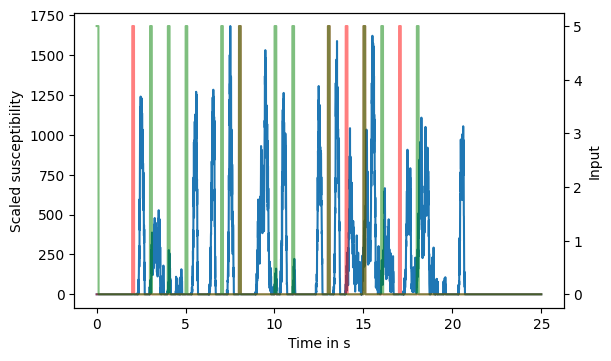

In [135]:
#Visualize each dataset
chosen_dataset = 10

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'rel_susceptibility'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(6, 3.5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False)
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False)
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False)
ax.set_xlabel("Time in s")
ax.set_ylabel("Scaled susceptibility")
ax2.set_ylabel("Input")

#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

fig.tight_layout(pad=.3)
fig.savefig("plot.png", dpi=300)